In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import Fourier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as ltb
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import re

In [2]:
# path to the dataset in Kaggle's notebook
path = '../input/store-sales-time-series-forecasting/'

In [3]:
df_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'])
df_holiday = pd.read_csv(path + 'holidays_events.csv', parse_dates=['date'])
df_stores = pd.read_csv(path + 'stores.csv')
df_transactions = pd.read_csv(path + 'transactions.csv', parse_dates=['date']).sort_values(["store_nbr", "date"])
df_train = pd.read_csv(path + 'train.csv', parse_dates=['date'])
df_test = pd.read_csv(path + 'test.csv', parse_dates=['date'])

## Data Exploaration

<AxesSubplot:xlabel='date', ylabel='sales'>

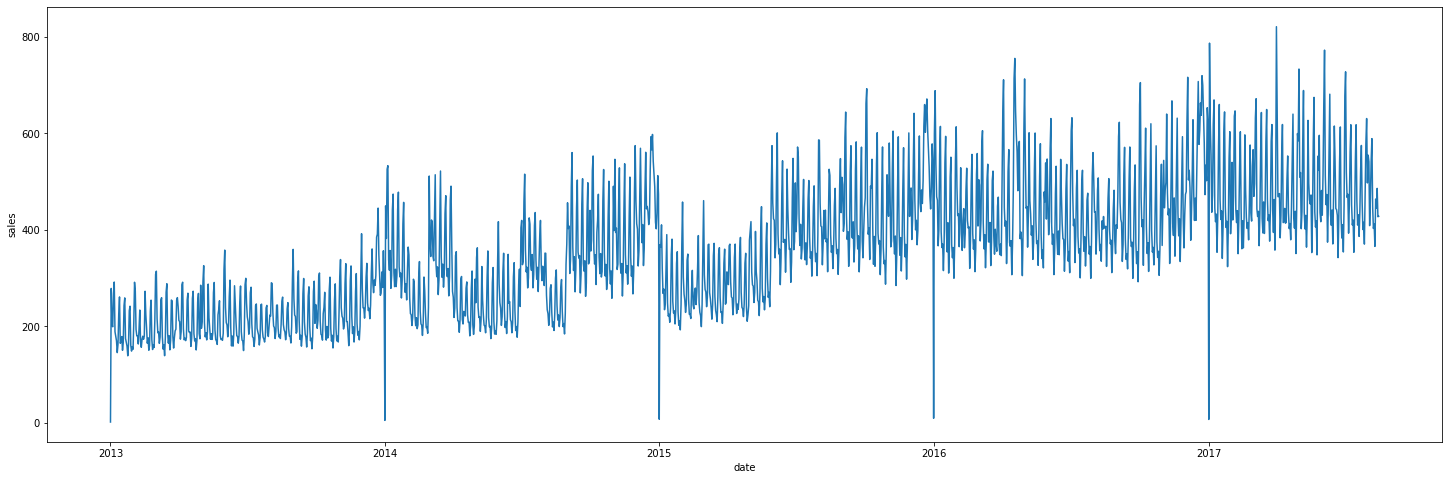

In [4]:
plt.figure(figsize=(25,8))
sns.lineplot(data=df_train.groupby('date').sales.mean().reset_index(), x = 'date', y = 'sales')

<AxesSubplot:xlabel='date', ylabel='sales'>

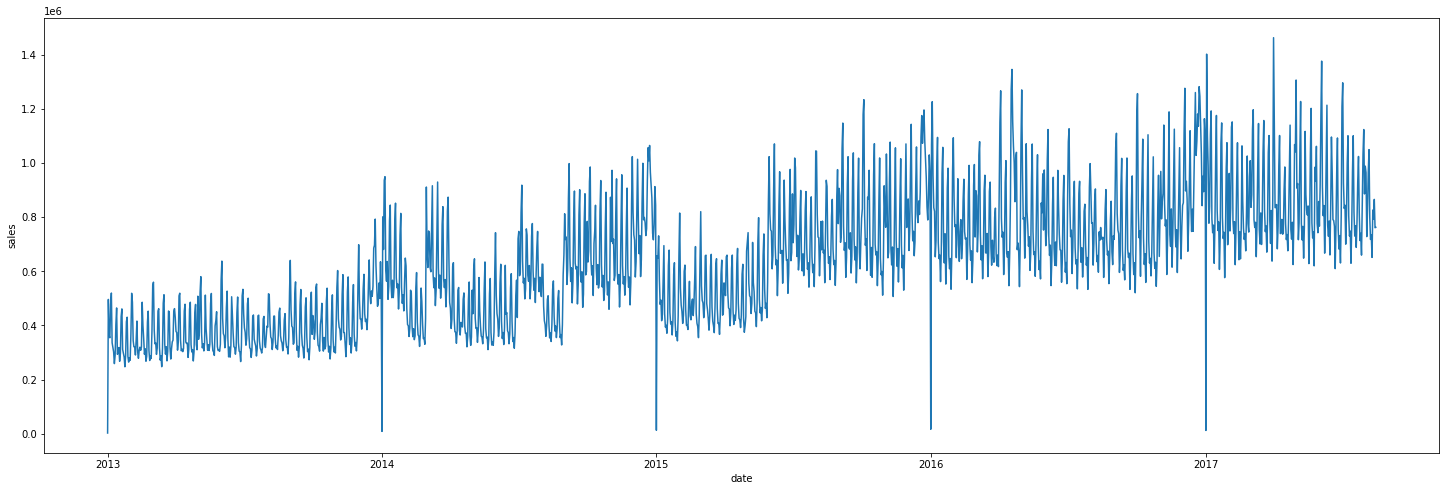

In [5]:
plt.figure(figsize=(25,8))
sns.lineplot(data=df_train.groupby('date').sales.sum().reset_index(), x = 'date', y = 'sales')

## Feature Engineering(Stores, Holidays, Oil, Transactions, Time series feature)

In [6]:
whole_df = pd.concat([df_train, df_test], axis=0)
whole_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


## Stores

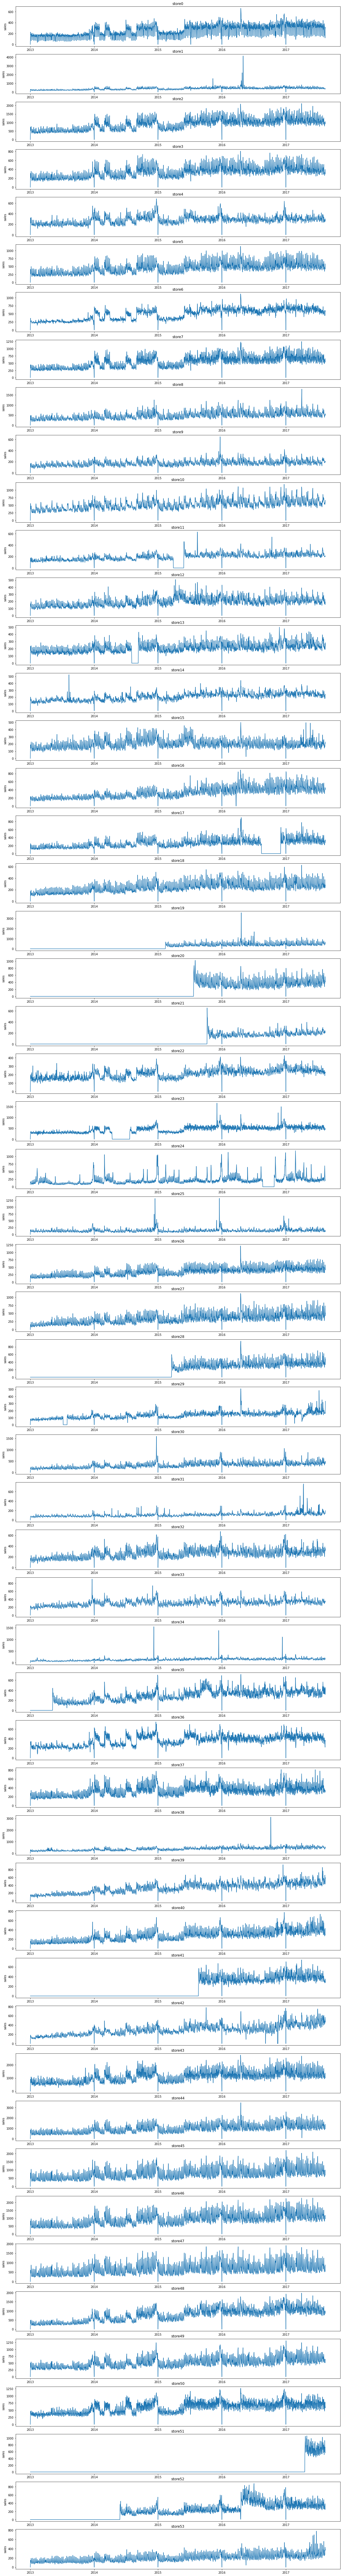

In [7]:
fig, axes = plt.subplots(54, 1, figsize=(20, 54*3))

for ax, i in zip(axes.flat, np.arange(0,54)):
    sns.lineplot(ax=axes[i], x=df_train[df_train['store_nbr'] == i+1].groupby('date').sales.mean().reset_index().date.values, y=df_train[df_train.store_nbr == i+1].groupby('date').sales.mean())
    ax.set_title('store'+ str(i)) 

We can see that some of the stores open later than 2013-01-01, and some of the stores temporaily close during some periods

In [8]:
df_city_unique = df_stores.groupby('city').store_nbr.unique().reset_index()
df_city_unique['length'] = df_city_unique['store_nbr'].str.len()
df_city_unique.sort_values(by='length')

,city,store_nbr,length
1,Babahoyo,[31],1
2,Cayambe,[11],1
19,Riobamba,[14],1
4,Daule,[27],1
5,El Carmen,[54],1
6,Esmeraldas,[43],1
7,Guaranda,[19],1
17,Quevedo,[33],1
9,Ibarra,[15],1
20,Salinas,[25],1


In [9]:
df_stores_f = df_stores.copy()
df_stores_f['openlate'] = df_stores_f['store_nbr'].isin([19, 20, 21, 28, 35, 41, 51, 52])
df_stores_f['is_unique'] = ~(df_stores_f['city'].isin(['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato']))
df_stores_f.head(15)

,store_nbr,city,state,type,cluster,openlate,is_unique
0,1,Quito,Pichincha,D,13,False,False
1,2,Quito,Pichincha,D,13,False,False
2,3,Quito,Pichincha,D,8,False,False
3,4,Quito,Pichincha,D,9,False,False
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,False,False
5,6,Quito,Pichincha,D,13,False,False
6,7,Quito,Pichincha,D,8,False,False
7,8,Quito,Pichincha,D,8,False,False
8,9,Quito,Pichincha,B,6,False,False
9,10,Quito,Pichincha,C,15,False,False


In [10]:
whole_df = pd.merge(whole_df, df_stores_f, how='left', left_on='store_nbr', right_on='store_nbr')
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,openlate,is_unique
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,False,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,False,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,False,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,False,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,False,False
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,False,False
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,False,False
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,False,False


## Holidays

In [11]:
df_holiday[df_holiday['type'] == 'Event']['description'].unique()

array(['Dia de la Madre', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar',
       'Mundial de futbol Brasil: Final', 'Black Friday', 'Cyber Monday',
       'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
       'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5',
       'Terremoto Manabi+6', 'Terremoto Manabi+7', 'Terremoto Manabi+8',
       'Terremoto Manabi+9', 'Terremoto Manabi+10', 'Terremoto Manabi+11',
       'Terremoto Manabi+12', 'Terremoto Manabi+13',
       'Terremoto Manabi+14', 'Terremoto Manabi+15',
       'Terremoto Manabi+16', 'Terremoto Manabi+17',
       'Terremoto Manabi+18', 'Terremoto 

In [12]:
whole_df['is_closed'] = whole_df.groupby(['date','store_nbr']).sales.transform(lambda x: True if x.sum() == 0 else False)
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,openlate,is_unique,is_closed
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,False,False,True
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,False,False,True
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,False,False,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,False,False,True
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,False,False,True
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,False,False,True
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,False,False,True
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,False,False,True


In [13]:
whole_df.loc[(whole_df['date'].dt.year==2017) & 
         (whole_df['date'].dt.month == 8) & 
         (whole_df['date'].dt.day >= 16),'is_closed'] = False
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,openlate,is_unique,is_closed
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,False,False,True
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,False,False,True
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,False,False,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,False,False,True
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,False,False,False
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,False,False,False
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,False,False,False
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,False,False,False


In [14]:
whole_df[(whole_df['date'] >= '2017-08-16') & (whole_df['is_closed'] == True)]

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,openlate,is_unique,is_closed


In [15]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

### only consider national holiday
df_national = df_holiday[df_holiday['locale'] == 'National']

### The objective of holiday is to determine that day will have negative or positive impact on the sales more precisely.
### And one thing to be noticed, one day might have multiple events, we could just simply consider the first one 
df_national = df_national.groupby('date').first()
calendar = pd.merge(calendar, df_national, how='left', left_index=True, right_index=True)
calendar['wd'] = calendar.index.dayofweek <= 4
# positive impact: work day, events = futbul, dia de la madre, black friday
# negative impact: holiday and transferred = False, additional, Transfer
calendar.loc[(calendar['type'] == 'Holiday') & (calendar['transferred'] == False), 'wd'] = False
calendar.loc[(calendar['type'] == 'Holiday') & (calendar['transferred'] == True), 'wd'] = True
calendar.loc[calendar['type'] == 'Work Day', 'wd'] = True
calendar.loc[calendar['type'] == 'Additional', 'wd'] = False
calendar.loc[calendar['type'] == 'Transfer', 'wd'] = False
calendar.loc[(calendar['type'] == 'Event') & ((calendar['description'].str.contains('futbol'))|
                                          (calendar['description'].str.contains('Dia de la Madre'))|
                                          (calendar['description'].str.contains('Black Friday'))
                                         ), 'wd'] = True
calendar.loc[(calendar['type'] == 'Event') & ((calendar['description'].str.contains('Cyber Monday'))|
                                          (calendar['description'].str.contains('Manabi'))
                                         ), 'wd'] = False
calendar['firstdayofyear'] = calendar['description'] == 'Primer dia del ano'
calendar

,type,locale,locale_name,description,transferred,wd,firstdayofyear
2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,False,True
2013-01-02,NaN,NaN,NaN,NaN,NaN,True,False
2013-01-03,NaN,NaN,NaN,NaN,NaN,True,False
2013-01-04,NaN,NaN,NaN,NaN,NaN,True,False
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,True,False
...,...,...,...,...,...,...,...
2017-08-27,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-28,NaN,NaN,NaN,NaN,NaN,True,False
2017-08-29,NaN,NaN,NaN,NaN,NaN,True,False
2017-08-30,NaN,NaN,NaN,NaN,NaN,True,False


In [16]:
whole_df = pd.merge(whole_df, calendar.reset_index(), how = 'left', left_on = 'date', right_on = 'index')

In [17]:
whole_df = whole_df.drop(columns=['description', 'locale', 'locale_name', 'transferred', 'index'])
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,openlate,is_unique,is_closed,type_y,wd,firstdayofyear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,False,False,True,Holiday,False,True
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,False,False,True,Holiday,False,True
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,False,False,True,Holiday,False,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,False,False,True,Holiday,False,True
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,False,False,True,Holiday,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,False,False,False,NaN,True,False
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,False,False,False,NaN,True,False
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,False,False,False,NaN,True,False
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,False,False,False,NaN,True,False


## Oil

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

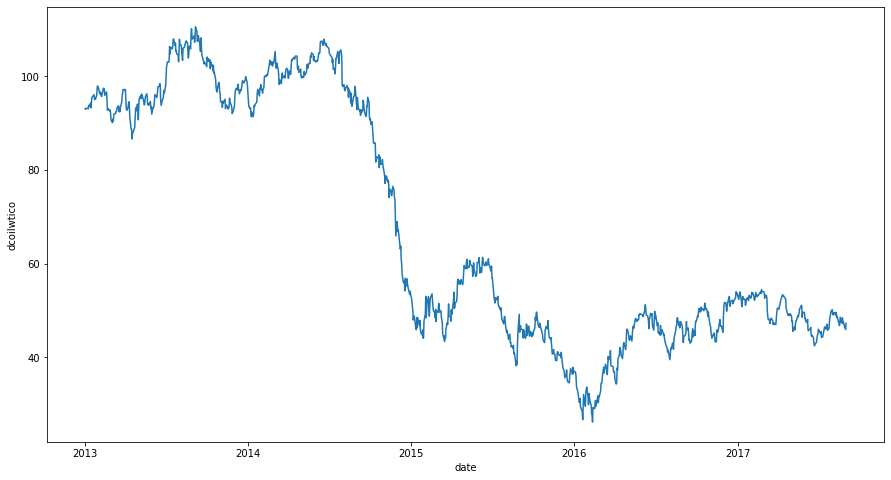

In [18]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_oil, x='date', y='dcoilwtico')

In [19]:
df_oil = df_oil.set_index('date')

In [20]:
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean(skipna=True)
df_oil['ma_oil_3'] = df_oil['dcoilwtico'].rolling(3).mean(skipna=True)
for i in [1,2,3,7]:
    df_oil['lagoil_' + str(i)] = df_oil['dcoilwtico'].shift(i)
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))
calendar = calendar.merge(df_oil, how='left',left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill',inplace=True)
calendar['ma_oil_3'].fillna(method='ffill',inplace=True)
calendar['lagoil_1'].fillna(method='ffill',inplace=True)
calendar['lagoil_2'].fillna(method='ffill',inplace=True)
calendar['lagoil_3'].fillna(method='ffill',inplace=True)
calendar['lagoil_7'].fillna(method='ffill',inplace=True)
calendar

,dcoilwtico,ma_oil,ma_oil_14,lagoil_1,lagoil_2,lagoil_3,lagoil_7
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,93.14,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,92.97,NaN,NaN,93.14,NaN,NaN,NaN
2013-01-04,93.12,NaN,93.076667,92.97,93.14,NaN,NaN
2013-01-05,NaN,NaN,93.076667,92.97,93.14,NaN,NaN
...,...,...,...,...,...,...,...
2017-08-27,NaN,47.720000,47.780000,47.24,48.45,47.65,46.80
2017-08-28,46.40,47.624286,47.096667,47.65,47.24,48.45,47.07
2017-08-29,46.46,47.320000,46.836667,46.40,47.65,47.24,48.59
2017-08-30,45.96,47.115714,46.273333,46.46,46.40,47.65,47.39


In [21]:
whole_df = pd.merge(whole_df, calendar.reset_index(), how='left', left_on='date',right_on='index')

In [22]:
whole_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'openlate', 'is_unique', 'is_closed',
       'type_y', 'wd', 'firstdayofyear', 'index', 'dcoilwtico', 'ma_oil',
       'ma_oil_14', 'lagoil_1', 'lagoil_2', 'lagoil_3', 'lagoil_7'],
      dtype='object')

In [23]:
whole_df = whole_df.drop(columns=['index'])
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,type_y,wd,firstdayofyear,dcoilwtico,ma_oil,ma_oil_14,lagoil_1,lagoil_2,lagoil_3,lagoil_7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Holiday,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Holiday,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Holiday,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,Holiday,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Holiday,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,NaN,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,NaN,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,NaN,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,NaN,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65


In [24]:
whole_df.isnull().sum()

id                      0
date                    0
store_nbr               0
family                  0
sales               28512
onpromotion             0
city                    0
state                   0
type_x                  0
cluster                 0
openlate                0
is_unique               0
is_closed               0
type_y            2774574
wd                      0
firstdayofyear          0
dcoilwtico         935550
ma_oil              16038
ma_oil_14            5346
lagoil_1             3564
lagoil_2             5346
lagoil_3            10692
lagoil_7            17820
dtype: int64

In [25]:
whole_df['total_onpromo'] = whole_df.groupby(['date','store_nbr']).onpromotion.transform(lambda x: x.sum())
whole_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,wd,firstdayofyear,dcoilwtico,ma_oil,ma_oil_14,lagoil_1,lagoil_2,lagoil_3,lagoil_7,total_onpromo
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,...,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65,223
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,...,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65,223
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,...,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65,223
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,...,True,False,47.26,47.06,46.56,45.96,46.46,46.4,47.65,223


In [26]:
whole_df_2 = whole_df.set_index('date').loc['2016-06-01':'2017-08-31']

## Time Series Features

In [27]:
whole_df_2['year'] = whole_df_2.index.year
whole_df_2['quarter'] = whole_df_2.index.quarter
#whole_df_2['day'] = whole_df_2.index.day
whole_df_2['dayofweek'] = whole_df_2.index.dayofweek
#whole_df_2['weekofyear'] = whole_df_2.index.isocalendar().week
whole_df_2['isweekend'] = whole_df_2.index.dayofweek > 4
whole_df_2['is_school'] = whole_df_2.index.month.isin([4,5,8,9])

whole_df_2 = pd.get_dummies(whole_df_2, columns=['year'],drop_first=True)
whole_df_2 = pd.get_dummies(whole_df_2, columns=['quarter'],drop_first=True)
whole_df_2 = pd.get_dummies(whole_df_2, columns=['dayofweek'],drop_first=True)

dp = DeterministicProcess(
    index= whole_df_2.index,
    order=1,
    seasonal=False,
    constant=False,
    additional_terms=[CalendarFourier(freq='A', order=5), CalendarFourier(freq='M', order=2), CalendarFourier(freq='W', order=4)],
    drop=True
)

whole_dp = dp.in_sample()
whole_df_2 = pd.concat([whole_df_2, whole_dp], axis=1)

In [28]:
whole_df_2

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,openlate,...,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,2216808,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,False,...,0.000000,1.00000,0.000000,1.000000,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2016-06-01,2216809,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,False,...,0.000000,1.00000,0.000000,1.000000,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2016-06-01,2216810,1,BEAUTY,4.0,0,Quito,Pichincha,D,13,False,...,0.000000,1.00000,0.000000,1.000000,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2016-06-01,2216811,1,BEVERAGES,2199.0,37,Quito,Pichincha,D,13,False,...,0.000000,1.00000,0.000000,1.000000,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2016-06-01,2216812,1,BOOKS,0.0,0,Quito,Pichincha,D,13,False,...,0.000000,1.00000,0.000000,1.000000,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,NaN,1,Quito,Pichincha,B,6,False,...,-0.201299,0.97953,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-08-31,3029396,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,False,...,-0.201299,0.97953,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2017-08-31,3029397,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,False,...,-0.201299,0.97953,-0.394356,0.918958,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521


## helper function

In [38]:
def create_sample_weights(X, target_date, weight=0.9):
    extra_weight_days = X.index.get_level_values('date') > target_date
    return np.array(list(map(lambda x: np.exp(-weight) if x == 0 else 1, extra_weight_days.astype('int'))))

In [39]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 10
#This section applies the framework of Regressor Hyperparamaters public notebook by Rizky Anugrah Ananto.
#The models we use ourselves are the optimal solutions for us obtained by careful selection and many attempts.
#For example, ridge () is not as good as LinearRegression ()。Separating families such as "SCHOOL" and "BOOK" out, and use GradientBoosting and ExtraTrees or other models are not as good as the current model under our feature engineering.
class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        lr = LinearRegression()
        extra_reg = ExtraTreesRegressor()
        #ltb_reg = ltb.LGBMRegressor()
        #rf = RandomForestRegressor()
        model = VotingRegressor([('lr', lr),('extra_reg',extra_reg)])
            
        model.fit(X, y, sample_weight=create_sample_weights(X, '2017-07-01'))

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

## model and final result

In [40]:
whole_df_2.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'type_x', 'cluster', 'openlate', 'is_unique', 'is_closed', 'type_y',
       'wd', 'firstdayofyear', 'dcoilwtico', 'ma_oil', 'ma_oil_14', 'lagoil_1',
       'lagoil_2', 'lagoil_3', 'lagoil_7', 'total_onpromo', 'isweekend',
       'is_school', 'year_2017', 'quarter_2', 'quarter_3', 'quarter_4',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6', 'trend', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)',
       'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)', 'cos(5,freq=A-DEC)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)'],
      dtype='object')

In [49]:
df = whole_df_2.loc[:'2017-08-31',:].reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()
y = np.log1p(df.loc[:,'sales'].unstack(['store_nbr', 'family']))
cols = ['openlate', 'is_unique', 'is_closed',
       'wd', 'firstdayofyear', 'ma_oil', 'ma_oil_3', 'lagoil_1',
       'lagoil_2', 'lagoil_3', 'lagoil_7',  'isweekend',
       'is_school', 'year_2017', 'quarter_2', 'quarter_3', 'quarter_4',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6', 'trend', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)',
       'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)', 'cos(5,freq=A-DEC)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
       'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']
X = df.loc[:, cols]
X = X.groupby('date').first()
X_train_1 = X.loc['2016-06-01':'2017-08-15',:]
X_test_1 = X.loc['2017-08-16':'2017-08-31',:]
y_train_1 = y.loc['2016-06-01':'2017-08-15']
y_test_1 = y.loc['2017-08-16':'2017-08-31']

y_train_1 = np.empty(((pd.Timestamp('2017-08-31') - pd.Timestamp('2016-06-01')).days - 16, 0))
y_test_1 = np.empty((16,0))
predict_y_train = np.empty(((pd.Timestamp('2017-08-31') - pd.Timestamp('2016-06-01')).days - 16, 0))
predict_y_test = np.empty((16,0))


Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Fit Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:

for i in whole_df_2.store_nbr.unique():
    y = np.log1p(df.loc[i,'sales'].unstack(['family']))
    X = df.loc[i, cols]
    X = X.groupby('date').first()
    X_train = X.loc['2016-06-01':'2017-08-15',:]
    X_test = X.loc['2017-08-16':'2017-08-31',:]
    y_train = y.loc['2016-06-01':'2017-08-15']
    y_test = y.loc['2017-08-16':'2017-08-31']
    
    model = CustomRegressor(n_jobs=-1, verbose=1)
    model.fit(X_train, y_train)
    predict_y_train_re = model.predict(X_train)
    predict_y_test_re = model.predict(X_test)
    
    y_train_1 = np.append(y_train_1, y_train, axis=1)
    y_test_1 = np.append(y_test_1, y_test, axis=1)
    predict_y_train = np.append(predict_y_train, predict_y_train_re, axis=1)
    predict_y_test = np.append(predict_y_test, predict_y_test_re, axis=1)
    

    

In [ ]:
iterables = [whole_df_2.store_nbr.unique(), whole_df_2.family.sort_values().unique()]
index = pd.MultiIndex.from_product(iterables, names=['store_nbr', 'family'])
    
y_train_1 = pd.DataFrame(y_train_1, columns=index, index=X_train_1.index)
y_test_1 = pd.DataFrame(y_test_1, columns=index, index=X_test_1.index)
predict_y_train = pd.DataFrame(predict_y_train, columns=y_train_1.columns, index=y_train_1.index)
predict_y_test = pd.DataFrame(predict_y_test, columns=y_test_1.columns, index=y_test_1.index)
    
   
y_train_1 = y_train_1.stack(['store_nbr', 'family'])
y_test_1 = y_test_1.stack(['store_nbr', 'family'])
y = pd.concat([y_train_1, y_test_1])
    
predict_y_train = predict_y_train.stack(['store_nbr', 'family'])
predict_y_test = predict_y_test.stack(['store_nbr', 'family'])
    
predict_y = pd.concat([pd.Series(predict_y_train).apply(lambda x: 0 if x<0 else x), pd.Series(predict_y_test).apply(lambda x: 0 if x<0 else x)])

In [50]:
df.reset_index()
y = pd.Series(np.exp(predict_y.values) - 1, index=predict_y.index)
sub = df.reset_index().set_index(['date', 'store_nbr', 'family']).sort_index().loc['2016-06-01':, 'id']
final = pd.concat([sub, y], axis=1).rename(columns={0:'sales'})
final['sales'] = final['sales'].apply(lambda x: 0 if x<0 else x) 
final = final.loc['2017-08-16':]

In [51]:
final

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     3.586206
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     4.107900
                     BEVERAGES                   3000891  2372.522432
                     BOOKS                       3000892     0.135287
...                                                  ...          ...
2017-08-31 54        POULTRY                     3029263    47.288004
                     PREPARED FOODS              3029264    74.075661
                     PRODUCE                     3029265   500.550226
                     SCHOOL AND OFFICE SUPPLIES  3029266     0.000000
                     SEAFOOD                     3029267     1.429663

[28512 rows x 2 columns]

In [52]:
final.to_csv('submission.csv', index=False)